<p align="center">
    <img src="images/RFM-CLTV.png" alt="drawing" width="1000"/>

# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# # Basic libraries
# 
import pandas   as pd
import numpy    as np
import datetime as dt

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Visualization libraries
#
import matplotlib.pyplot as plt
import seaborn           as sns

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Sklearn library
#
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster       import KMeans

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Feature engine library
#
import feature_engine
from   feature_engine.outliers import Winsorizer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# User library
#
from   utils.snake_plot import *
from   utils.check_skew import *

# Import data

In [3]:
# Load Dataset
#
df = pd.read_csv('Data/OnlineRetail.csv', encoding="ISO-8859-1")

print('[INFO] Number of instances: ', df.shape[0])
print('[INFO] Number of features:  ', df.shape[1])

# Visualize DataFrame
#
df.head( 3 )

[INFO] Number of instances:  541909
[INFO] Number of features:   8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/10 8:26,2.75,17850.0,United Kingdom


## Data Pre-processing

**Observations/Findings:**

- The min and max value for Quantity is 80995, this could represent cancelled or returned orders.
- The UnitPrice also have few negative values which is uncommon,these transactions could represent cancelled orders by customers or bad-debt incurred by the business.
- Bad debt adjustments will be dropped from the dataset as these do not represent actual sales. 

We need to clean the above values by removing from the dataset


- There are almost 25% missing CustomerID. We need to remove them as there is no way we can get the number of CustomerID
- As customer clusters may vary by geography, we will restrict the data to only United Kingdom customers, which contains most of our customers historical data (~90%).

In [4]:
# More than 90% of customers are 'United Kingdom' customers.
#
df = df[df.Country == 'United Kingdom']

In [5]:
# Removing the negative values from UnitPrice and Quantity
#
df = df[df[ 'Quantity'  ] > 0]
df = df[df[ 'UnitPrice' ] > 0]

# Removing the Null values from the data.
#
df = df[ pd.notnull(df['CustomerID']) ]

In [6]:
# Replace 'InvoiceDate' to 'Date'
#
df = df.rename(columns = {'InvoiceDate': 'Date'})


# Convert 'Date' to datetime64
#
df[ 'Date' ] = df[ 'Date' ].astype( 'datetime64' )

In [7]:
# Convert 'CustomerID' to int
#
df[ 'CustomerID' ] = df[ 'CustomerID' ].astype( 'int' )

**Note:** We have all the crucial information we need

- Customer ID
- Unit Price
- Quantity
- Invoice Date

### Calculate Revenue

In [8]:
# Revenue = Order Count * Average Revenue per Order
#
df['Revenue'] = df['Quantity'] * df['UnitPrice']

## Aggregating the Orders by Month

In [9]:
df_agg = df.resample('M', on = 'Date').sum()

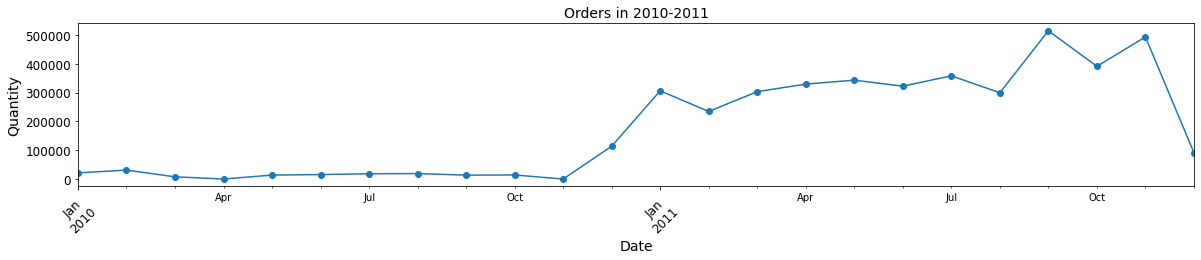

In [10]:
df_agg[ 'Quantity' ].plot(color='tab:Blue', marker='o', figsize = (20, 3))


plt.title('Orders in 2010-2011', size = 14)
#
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12)
#
plt.xlabel('Date', size = 14)
plt.ylabel('Quantity', size = 14);
#
plt.legend([], frameon = False)


# RFM Analysis

**Recency-Frequency-Monetary**
    
    
RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.

* Recency — how long it’s been since a customer bought something from us
* Frequency — how often a customer buys from us
* Monetary value — the total value of purchases a customer has made

### Keep useful feature for RFM analysis

- CustomerID
- Date
- InvoiceNo
- Revenue

In [11]:
df = df[ ['CustomerID' , 'Date', 'InvoiceNo', 'Revenue'] ]

## Recency

In [12]:
# The last invoice date is 2011–12–11, we will use this date to calculate Recency
NOW = dt.date(2011, 12, 11) 

df['Date'] = pd.DatetimeIndex(df[ 'Date' ]).date

In [13]:
# Create Recency DataFrame
# 
df_Recency = df.groupby('CustomerID').agg( {'Date': lambda date: (NOW - date.max()).days} )
df_Recency.columns = ['Recency']

# Recency DataFrame visualization
#
df_Recency.head( 5 )

,Recency
CustomerID,
12346,327
12747,24
12748,6
12749,24
12820,46


## Frequency

In [14]:
# Create Frequeny DataFrame
#
df_Frequency = df.groupby('CustomerID').agg( {'InvoiceNo' : lambda x: x.nunique()})
df_Frequency.rename(columns = {'InvoiceNo' : 'Frequency'}, inplace = True)

# Frequeny DataFrame visualization
#
df_Frequency.head( 5 )

,Frequency
CustomerID,
12346,1
12747,11
12748,209
12749,5
12820,4


## Monetarty

In [15]:
# Create Monetarty DataFrame
#
df_Monetarty = df.groupby('CustomerID').agg( {'Revenue' : lambda x: x.sum()} )
df_Monetarty.rename(columns = {'Revenue' : 'Monetary'}, inplace = True)

# Monetarty DataFrame visualization
#
df_Monetarty.head( 5 )

,Monetary
CustomerID,
12346,77183.60
12747,4196.01
12748,33719.73
12749,4090.88
12820,942.34


In [16]:
# Merge Recency, Frequency & Monetary DataFrames
#
RFM = df_Recency.merge(df_Frequency, left_on = 'CustomerID', right_on = 'CustomerID')
#
RFM = RFM.merge(df_Monetarty, left_on = 'CustomerID', right_on = 'CustomerID')

RFM.reset_index(inplace = True)
# RFM DataFrame visualization
#
RFM.head( 5 )

,CustomerID,Recency,Frequency,Monetary
0,12346,327,1,77183.60
1,12747,24,11,4196.01
2,12748,6,209,33719.73
3,12749,24,5,4090.88
4,12820,46,4,942.34


In [17]:
# Recency - Frequency - Monetarty could be calculated together using the following code
# ---------------------------------------------------------------------------
#
# 
# # RFM = df.groupby('CustomerID').agg( {'Date'       :  lambda date: (NOW - date.max()).days
#                                        'InvoiceNo'  : lambda x: x.nunique(),
#                                        'Revenue'    : lambda x: x.sum()})
#
# RFM.columns = ['Recency', 'Frequency', 'Monetary']
# RFM.head( 5 )

## Calculate RFM-Scores

**Methodology:** Next, we split the metrics into segments using quantiles. 

We will assign a score from 1 to 5 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 5 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

### Calculate R_score, F_score, M_score

In [18]:
# Calculate R_score, F_score, M_score
# 
RFM['R_score'] = pd.qcut(RFM['Recency'],                          5, labels = [5, 4, 3, 2, 1]).astype('int')
RFM['F_score'] = pd.qcut(RFM['Frequency'].rank(method = 'first'), 5, labels = [1, 2, 3, 4, 5]).astype('int')
RFM['M_score'] = pd.qcut(RFM['Monetary'],                         5, labels = [1, 2, 3, 4, 5]).astype('int')

### Calculating the RFM_Segment & RFM-score

RFM_Segment = str(R_score) + str(F_score) + str(M_score)
RFM_Score   = R_score + F_score + M_score

In [19]:
# Calculate RFM_Segment
# 
RFM['RFM_Segment'] = RFM.R_score.map(str) + RFM.F_score.map(str) + RFM.M_score.map(str)

# Calculate RFM_Score
#
RFM[ 'RFM_Score' ] = RFM[ 'R_score' ] + RFM[ 'F_score' ] + RFM[ 'M_score' ]

# Sort DataFrame based on RFM-Score
#
RFM.sort_values(by = 'RFM_Score', inplace = True)

In [20]:
# Remove some outliers, namely
# Extreme Monetary, with only one sale
#
RemovedIDs = RFM[ ( (RFM['Monetary'] > np.quantile(RFM['Monetary'], 0.95)) & (RFM['Frequency'] == 1) ) ].CustomerID
print('[INFO] Remove some outliers, Extreme Monetary, with only one sale')
print('[INFO] Number of IDs to be removed: ', len(RemovedIDs))
#
RFM = RFM[ ~RFM['CustomerID'].isin( RemovedIDs ) ]
df  = df[  ~df['CustomerID'].isin( RemovedIDs )  ]
#
# This could be removed, depending on the selected strategy.

[INFO] Remove some outliers, Extreme Monetary, with only one sale
[INFO] Number of IDs to be removed:  1


### Visualization 

- DataFrame visualization
- RFM-Segment & RFM-Score bar-plots
- Average Revenue Per User

In [21]:
# RFM DataFrame visualization
#
RFM.head( 5 )

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
1875,15454,364,1,179.10,1,1,1,111,3
1748,15276,245,1,135.31,1,1,1,111,3
636,13716,271,1,138.28,1,1,1,111,3
143,13017,302,1,204.00,1,1,1,111,3
1759,15292,203,1,180.94,1,1,1,111,3


#### RFM-Segment & RFM-Score bar-plots

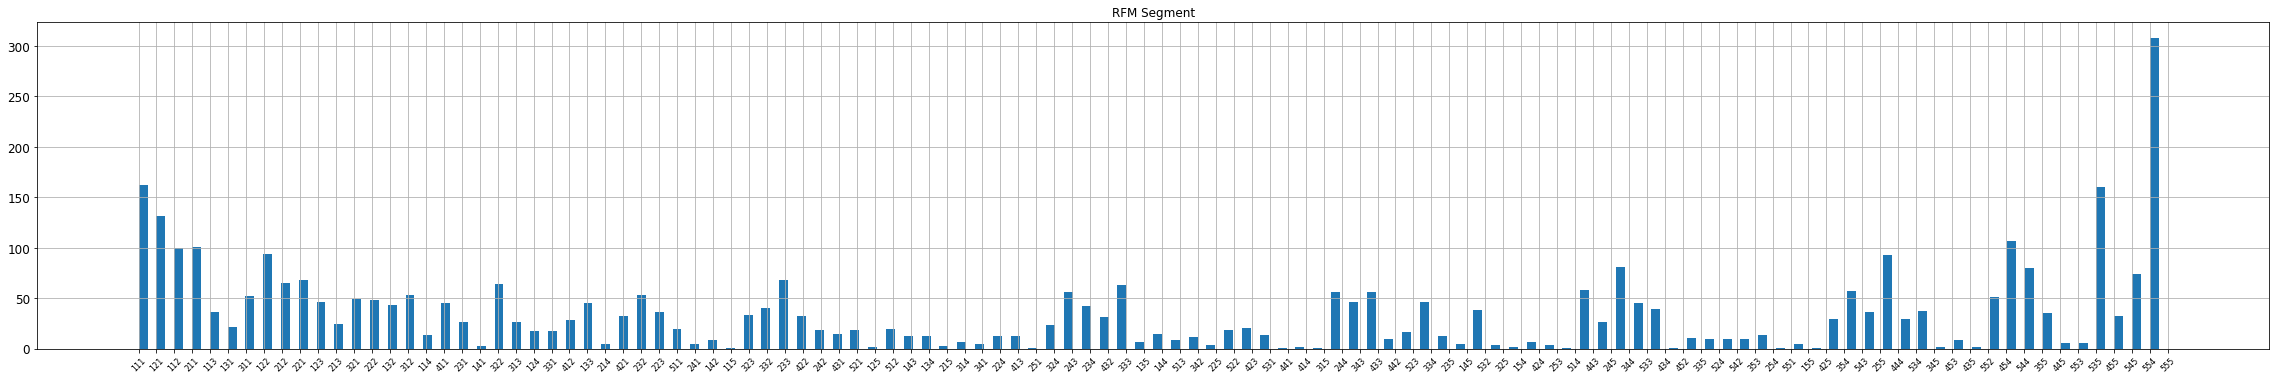

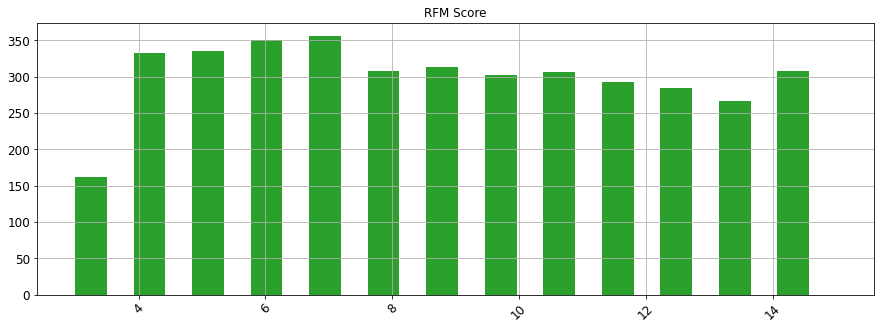

In [22]:
RFM['RFM_Segment'].hist( figsize = (40, 6), bins = RFM.RFM_Segment.nunique(), width = 0.5, color = 'tab:blue')
plt.title('RFM Segment')
plt.xticks(rotation = 45, size = 8);
plt.yticks(size = 12);
plt.show()

RFM['RFM_Score'].hist( figsize = (15, 5), bins = RFM.RFM_Score.nunique(), width = 0.5, color = 'tab:green')
plt.title('RFM Score')
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12);
plt.show()


#### Average Revenue Per User

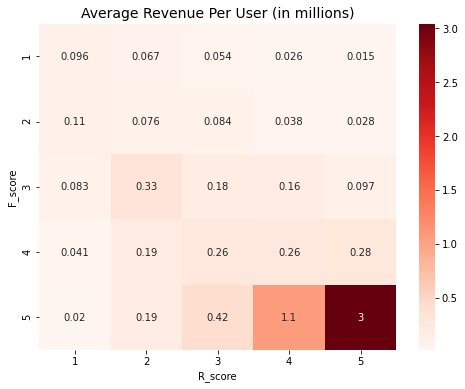

In [23]:
ARPU = RFM.groupby(['R_score', 'F_score']).sum()[['Monetary']].reset_index().pivot('F_score', 'R_score', 'Monetary')


plt.figure( figsize = (8, 6) );
#
sns.heatmap( ARPU / 1.e+6, annot = True, cmap = 'Reds');
plt.title('Average Revenue Per User (in millions)', size = 14);

## Customer characterization

After some calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

- **Champions:** Bought recently, buy often and spend the most.
- **Loyal customers:** Buy on a regular basis. Responsive to promotions.
- **Potential loyalist:** Recent customers with average frequency.
- **Recent customers:** Bought most recently, but not often.
- **Promising:** Recent shoppers, but haven’t spent much.
- **Needs attention:** Above average recency, frequency and monetary values. May not have bought very recently though.
- **About to sleep:** Below average recency and frequency. Will lose them if not reactivated.
- **At risk:** Some time since they’ve purchased. Need to bring them back!
- **Can’t lose them:** Used to purchase frequently but haven’t returned for a long time.
- **Hibernating:** Last purchase was long back and low number of orders. May be lost.

**4-class scheme**

<img src="images/Customer_segmentation_4-class.png" alt="drawing" width="500"/>

    
**5-class scheme**

<img src="images/Customer_segmentation_5-class.png" alt="drawing" width="550"/>

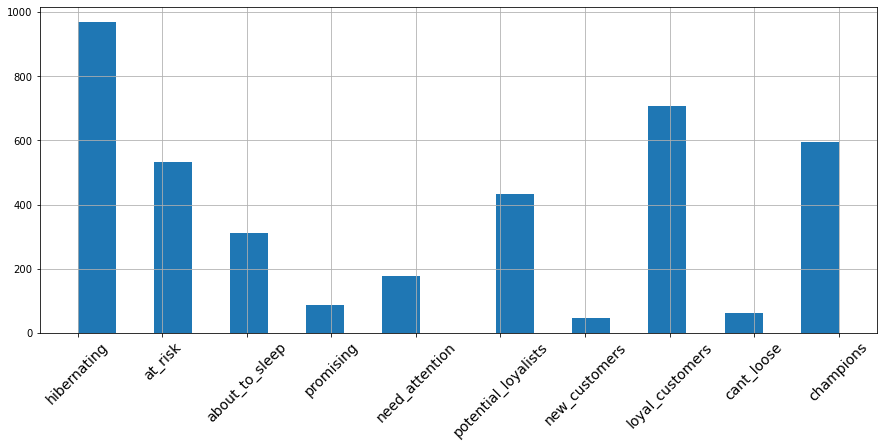

In [24]:
# Create human friendly RFM labels

# Segment map - In case of 4 bins
# segt_map = {
#     r'1[1-2]': 'Hibernating',
#     r'13': 'At risk',
#     r'14': 'Can\'t loose them',
#     r'21': 'About to sleep',
#     r'22': 'Need attention',
#     r'[2-3][3-4]': 'Loyal customers',
#     r'31': 'Promising',
#     r'41': 'New customers',
#     r'[3-4]2': 'Potential loyalists',
#     r'4[3-4]': 'Champions'
# }

# Segment map - In case of 5 bins
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

RFM['Segment'] = RFM['R_score'].map(str) + RFM['F_score'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)

RFM['Segment'].hist( figsize = (15, 6), bins = RFM['Segment'].nunique()*2, color = 'tab:blue')
plt.xticks( size = 14, rotation = 45);

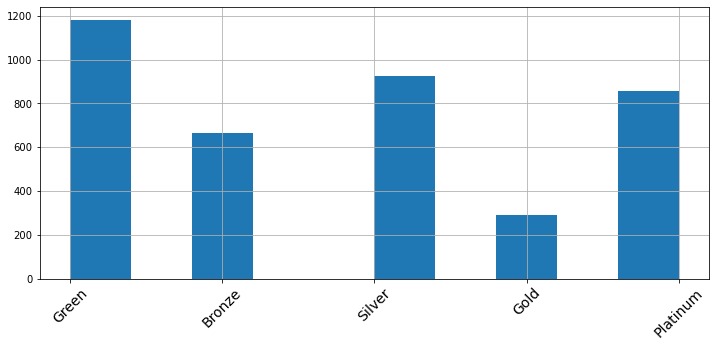

In [25]:
# Create some human friendly labels for the scores
#
RFM[ 'Score' ] = 'Green'
RFM.loc[ RFM['RFM_Score'] >  6, 'Score' ] = 'Bronze' 
RFM.loc[ RFM['RFM_Score'] >  8, 'Score' ] = 'Silver' 
RFM.loc[ RFM['RFM_Score'] > 11, 'Score' ] = 'Gold' 
RFM.loc[ RFM['RFM_Score'] > 12, 'Score' ] = 'Platinum'

# DataFrame visualization
#
RFM[ 'Score' ].hist( figsize = (12, 5));
plt.xticks( size = 14, rotation = 45);

## K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation. 

### Skewness check

Plotting distribution charts to check for skewness

Recency's: Skew: 1.9245094462584071, : SkewtestResult(statistic=33.34069789744037, pvalue=9.936618739179749e-244)


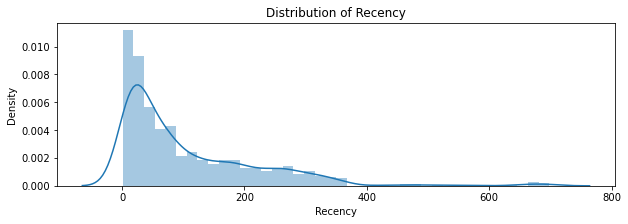

Frequency's: Skew: 10.746961292788324, : SkewtestResult(statistic=68.54304953170006, pvalue=0.0)


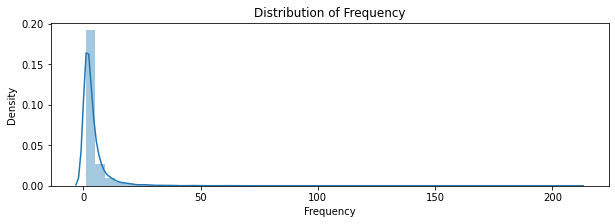

Monetary's: Skew: 20.734482503010387, : SkewtestResult(statistic=82.29986955964505, pvalue=0.0)


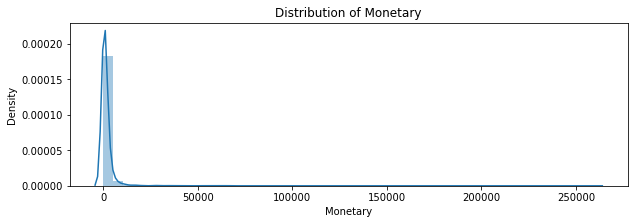

In [26]:
# Plot all Distrubution graphs of Recency, Frequency & Monetary

check_skew(RFM, 'Recency');

check_skew(RFM, 'Frequency');

check_skew(RFM, 'Monetary');

#### Data transformation

The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.

In [27]:
# # Make a copy of the DataFrame
# # 
# RFM_log = RFM[ ['Recency', 'Frequency', 'Monetary']].copy()

# # Log features
# #
# VALUE = max(0, -RFM_log.min().min()) + 1
# RFM_log = np.log(RFM_log + VALUE)


# Setup transformer
pt = PowerTransformer(method = 'box-cox') # method = {'yeo-johnson', 'box-cox'}

# Apply transformation
RFM_log = pd.DataFrame(data = pt.fit_transform( RFM[ ['Recency', 'Frequency', 'Monetary']] ),
                       columns = ['Recency', 'Frequency', 'Monetary'])

print('[INFO] Data were transformed')

[INFO] Data were transformed


Recency's: Skew: -0.0509704580482333, : SkewtestResult(statistic=-1.3042985874077486, pvalue=0.19213179676945613)


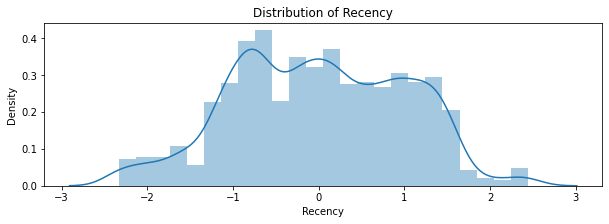

Frequency's: Skew: 0.1440230169096365, : SkewtestResult(statistic=3.669071668188207, pvalue=0.00024343283460942776)


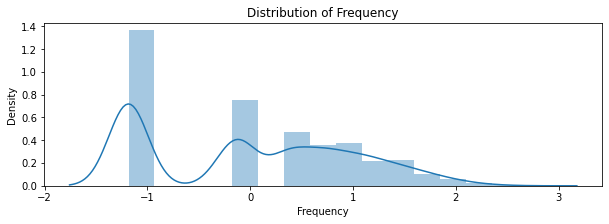

Monetary's: Skew: -0.014418629323513506, : SkewtestResult(statistic=-0.3691816341039014, pvalue=0.711992344335064)


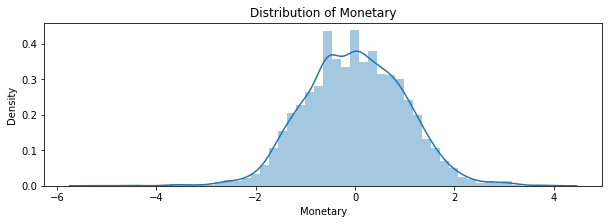

In [28]:
# Plot all Distrubution graphs of Recency, Frequency & Monetary
#
check_skew(RFM_log, 'Recency');

check_skew(RFM_log, 'Frequency');

check_skew(RFM_log, 'Monetary');

#### Winsorizing

Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. It is named after the engineer-turned-biostatistician Charles P. Winsor (1895–1951). The effect is the same as clipping in signal processing.

In [29]:
windsoriser = Winsorizer(tail      = 'both', # cap left, right or both tails 
                         fold      = 2,
                         variables = [ 'Recency', 'Frequency', 'Monetary']
                        )

windsoriser.fit( RFM_log )

RFM_log = windsoriser.transform( RFM_log )

### Standarization

Once the skewness is reduced, I standardised the data by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.

In [30]:
# Setup scaler
# 
scaler = StandardScaler()

# Fit scaler
scaler.fit( RFM_log )

RFM_log_scaled = pd.DataFrame(data    = scaler.transform(RFM_log), 
                              columns = RFM_log.columns)

### K-Means clustering process

### Finding the optimal number of clusters

In [31]:
from scipy.spatial.distance import cdist
from sklearn.metrics        import silhouette_score

distortions = [] 
inertias    = [] 
Clusters    = [ [] ]
Centroids   = [ [] ]
K = range(1, 11)
  
for k in K: 
    # Setup K-Means model     
    model = KMeans(n_clusters = k, random_state = 42)
    
    # Fit model
    model.fit( RFM_log_scaled )     

    # Store clusters
    Clusters  += [ model.labels_.tolist() ]
    
    # Get centroids
    Centroids += [ model.cluster_centers_ ]

    # Calculate distortions
    distortions.append( sum(np.min(cdist(RFM_log_scaled, model.cluster_centers_, 'euclidean'), axis = 1)) / RFM_log_scaled.shape[0] ) 

    # Calculate inertias
    inertias.append( model.inertia_ ) 
  
    # Calculate Silhouette score
    if (k > 1):
        Sil = silhouette_score(X     = RFM_log_scaled, 
                              labels = model.labels_)

        print('K = %2i Silhouette Score %.3f' % (k, Sil))
    

K =  2 Silhouette Score 0.441
K =  3 Silhouette Score 0.332
K =  4 Silhouette Score 0.351
K =  5 Silhouette Score 0.334
K =  6 Silhouette Score 0.332
K =  7 Silhouette Score 0.318
K =  8 Silhouette Score 0.310
K =  9 Silhouette Score 0.306
K = 10 Silhouette Score 0.297


#### Elbow Method using Distortion and Inertia

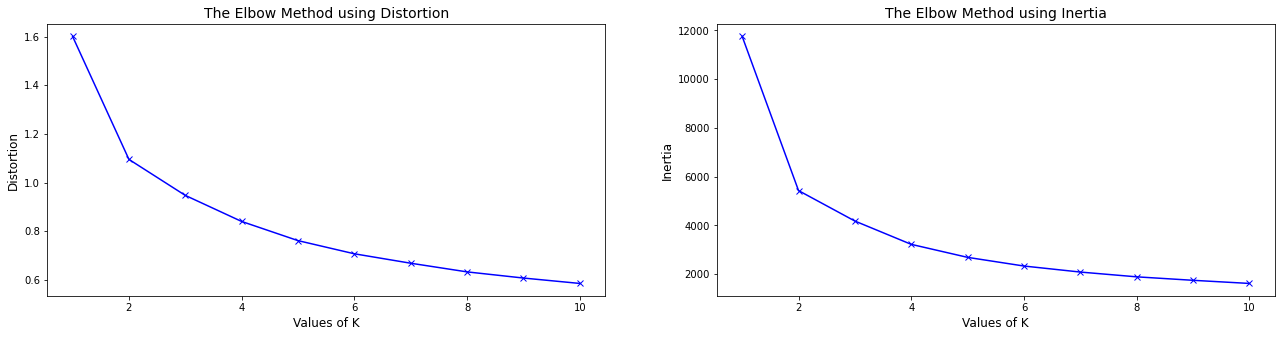

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (22, 5) )
#
ax[0].plot(K, distortions, 'bx-') 
ax[0].set_xlabel('Values of K', size = 12) 
ax[0].set_ylabel('Distortion', size = 12) 
ax[0].set_title('The Elbow Method using Distortion', size = 14) 
#
ax[1].plot(K, inertias, 'bx-') 
ax[1].set_xlabel('Values of K', size = 12) 
ax[1].set_ylabel('Inertia', size = 12) 
ax[1].set_title('The Elbow Method using Inertia', size = 14)
#
#
plt.show();


#### Cluster visualization

In [33]:
import umap

UMAP_arg    = { 'n_neighbors': 30, 
                'min_dist':    0.01 }

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Apply UMAP
#
umapModel = umap.UMAP(n_neighbors  = UMAP_arg['n_neighbors'],
                      min_dist     = UMAP_arg['min_dist'],
                      n_components = 2,
                      random_state = 42)

embeddings = umapModel.fit_transform( RFM_log_scaled[ ['Recency', 'Frequency', 'Monetary'] ].to_numpy() )

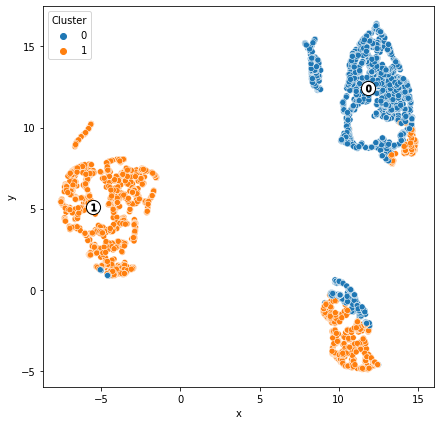

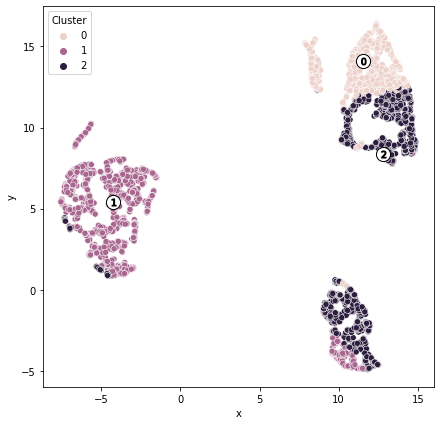

In [34]:
# Create DataFrame
# 
clustering_df = pd.DataFrame( embeddings, columns = ['x', 'y'] )

for k in [2, 3]:
        
    # Get Cluster    
    #
    clustering_df['Cluster'] = Clusters[k]


    # Clustering visualization in 2D
    #
    plt.figure( figsize = (7, 7) )
    sns.scatterplot(data = clustering_df, x = 'x', y = 'y', hue = 'Cluster')

    # Plot centroids
    #
    centers = umapModel.transform( Centroids[ k ] )
    plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate( centers ):
            plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s = 50, edgecolor='k')

    plt.show()

#### Snake plots

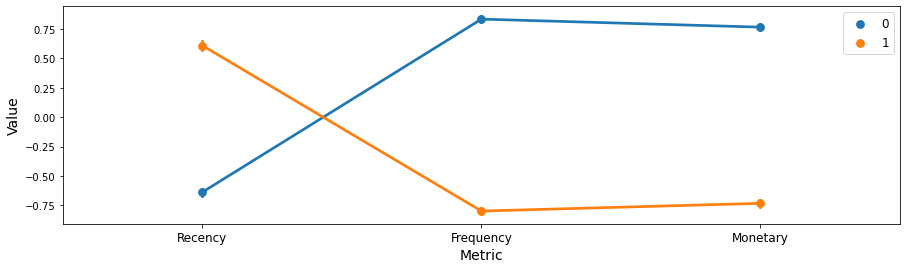

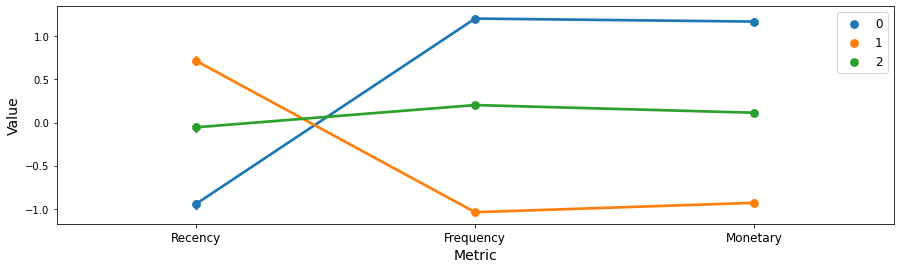

In [35]:
for k in [2, 3]:
    snake_plot(RFM_log_scaled.copy(), Clusters[k], RFM['CustomerID'])

### Clustering evaluation

- Silhouette visualizer

In [36]:
# Selected number of clusters
# 
n_clusters = 3

# Setup model
model = KMeans(n_clusters = n_clusters).fit( RFM_log_scaled ) 

# Fit model
model.fit( RFM_log_scaled )     

# Get Clustering-Results
RFM[ 'Cluster' ] = model.labels_

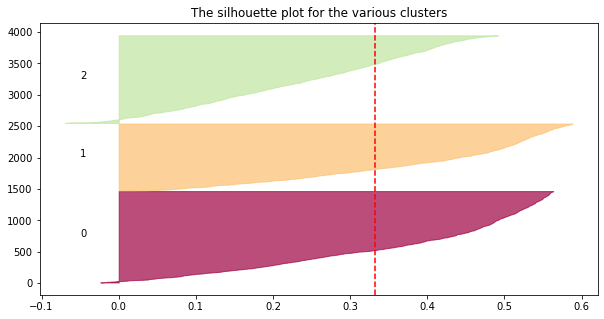

In [37]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

plt.figure( figsize = (10, 5))


Sil = silhouette_score(X      = RFM_log_scaled, 
                       labels = RFM[ 'Cluster' ])


sample_silhouette_values = silhouette_samples(X = RFM_log_scaled, labels = RFM['Cluster'])

y_lower = 10
for i in range( n_clusters ):
    ith_cluster_silhouette_values = sample_silhouette_values[ RFM['Cluster'] == i ]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
plt.axvline(x = Sil, color="red", linestyle="--")

# Set figure title
#
plt.title('The silhouette plot for the various clusters');

### Interpretation of the clusters formed using k-means
 

In [38]:
RFM.groupby(['Cluster']).agg({'Recency'   : 'mean',
                              'Frequency' : 'mean',
                              'Monetary'  :  ['mean', 'count']})

Recency  Frequency     Monetary      
               mean       mean         mean count
Cluster                                          
0        188.024022   1.137955   284.399191  1457
1         26.505629  10.272045  5226.473996  1066
2         82.710602   2.891834   892.132559  1396

CustomerID
Cluster Score               
0       Bronze           293
        Green           1155
        Silver             9
1       Gold             186
        Platinum         856
        Silver            24
2       Bronze           371
        Gold             107
        Green             25
        Platinum           3
        Silver           890

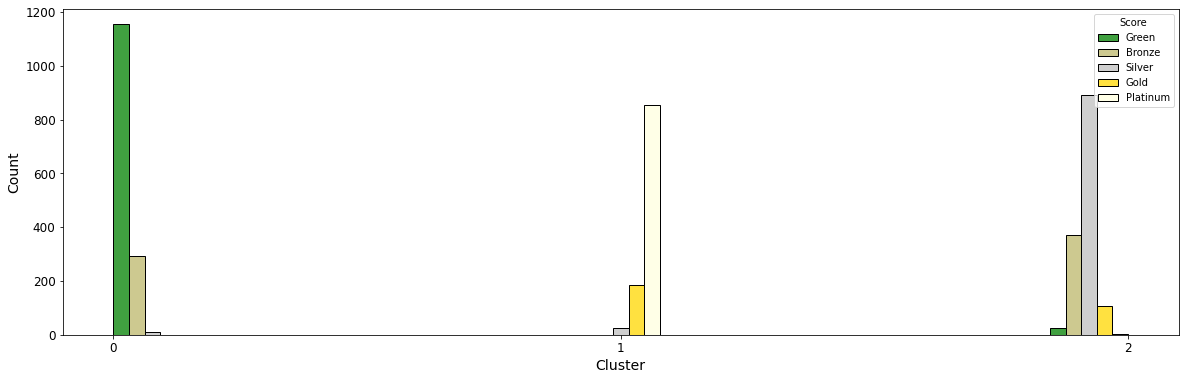

In [39]:
# Create an array with the colors you want to use
colors = ["green", "darkkhaki", "silver", "gold",  "lightyellow"]

# Set your custom color palette
sns.set_palette( sns.color_palette(colors) )



plt.figure( figsize = (20, 6) )
#
#
sns.histplot(data = RFM, x = 'Cluster', hue = 'Score', multiple="dodge", )
#
plt.xticks( np.arange(n_clusters), size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

RFM.groupby(['Cluster', 'Score']).count()[ ['CustomerID'] ]

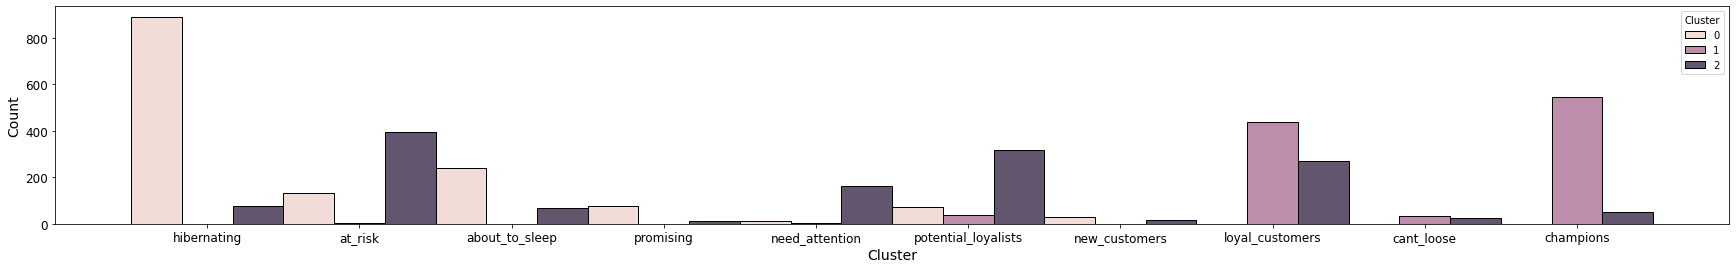

In [40]:
# Create an array with the colors you want to use
# colors = ["green", "darkkhaki", "silver", "gold",  "lightyellow"]

# Set your custom color palette
# sns.set_palette( sns.color_palette(colors) )



plt.figure( figsize = (30, 4) )
#
#
g = sns.histplot(data = RFM, hue = 'Cluster', x = 'Segment', multiple = 'dodge', color = "lime")
#
plt.xticks( size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);


# RFM.groupby(['Cluster', 'Segment']).count()[ ['CustomerID'] ]

# Customer Life-Time Value

<!-- <p align="center"> -->
<img src="images/CLTV.png" alt="drawing" width="1000"/>




*80% of the effect comes from 20% of the causes, this is known as 80/20 rule or Pareto principle...*

                                                            Vilfredo Pareto

## Calculate CLTV

In [41]:
def create_cltv_calculated( RFM ):

    dataframe = RFM.copy()

    # Average Order Value (AOV)
    dataframe['Average_Order_Value'] = dataframe['Monetary'] / dataframe['Frequency']

    # Purchase_Frequency (PM)
    dataframe["Purchase_Frequency"] = dataframe['Frequency'] / dataframe.shape[0]

    # Repeat rate & Churn rate
    repeat_rate = dataframe[dataframe['Frequency'] > 1].shape[0] / dataframe.shape[0]
    churn_rate  = 1 - repeat_rate

    # Profit Margin
    #
    dataframe['Profit_Margin'] = dataframe['Monetary'] * 0.10

    # Customer Value (CV)
    #
    dataframe['Customer_Value'] = (dataframe['Average_Order_Value'] * dataframe["Purchase_Frequency"])

    # Customer Life-Time Value (CLTV)
    #
    dataframe['CLTV'] = (dataframe['Customer_Value'] / churn_rate) * dataframe['Profit_Margin']


    # MinMax-scaling
    #
    # Setup scaler
    scaler = MinMaxScaler(feature_range=(1, 100))
    # Apply scaler
    dataframe["CLTV_calculated"] = scaler.fit_transform(dataframe[["CLTV"]])

    # Calculate CLTV segments
    dataframe["CLTV_calculated_segment"] = pd.qcut(dataframe["CLTV_calculated"], 4, labels = ['D', 'C', 'B', 'A'])

    dataframe = dataframe[[ "Recency", "Frequency", "Monetary", "Segment", "CLTV_calculated", "CLTV_calculated_segment"]]

    return dataframe

In [42]:
# Get Customer Segmentation based on RFM profile
# 
Customer_Segmentation_df = RFM[ ['CustomerID', 'Segment'] ].copy()


# Calculate RFM based on each user
#
RFM = df.groupby('CustomerID').agg( {'Date'       : lambda date: (date.max() - date.min()).days,
                                     'InvoiceNo'  : lambda x: x.nunique(),
                                     'Revenue'    : lambda x: x.mean()})

RFM.columns = ['Recency', 'Frequency', 'Monetary']



# Include Customer Segmentation based on RFM profile
#
RFM = RFM.join( Customer_Segmentation_df.set_index('CustomerID') )


RFM.head( 5 )

,Recency,Frequency,Monetary,Segment
CustomerID,,,,
12747,554,11,40.737961,loyal_customers
12748,692,209,7.338353,champions
12749,313,5,20.557186,loyal_customers
12820,282,4,15.971864,loyal_customers
12821,0,1,15.453333,hibernating


In [43]:
cltv_df = create_cltv_calculated( RFM.copy() )


cltv_df.head( 10 )

,Recency,Frequency,Monetary,Segment,CLTV_calculated,CLTV_calculated_segment
CustomerID,,,,,,
12747,554,11,40.737961,loyal_customers,1.000052,A
12748,692,209,7.338353,champions,1.000002,D
12749,313,5,20.557186,loyal_customers,1.000013,B
12820,282,4,15.971864,loyal_customers,1.000008,C
12821,0,1,15.453333,hibernating,1.000007,C
12822,17,2,20.627826,about_to_sleep,1.000013,B
12823,222,5,351.900000,loyal_customers,1.003887,A
12824,0,1,15.884800,promising,1.000008,C
12826,394,7,16.205714,loyal_customers,1.000008,C


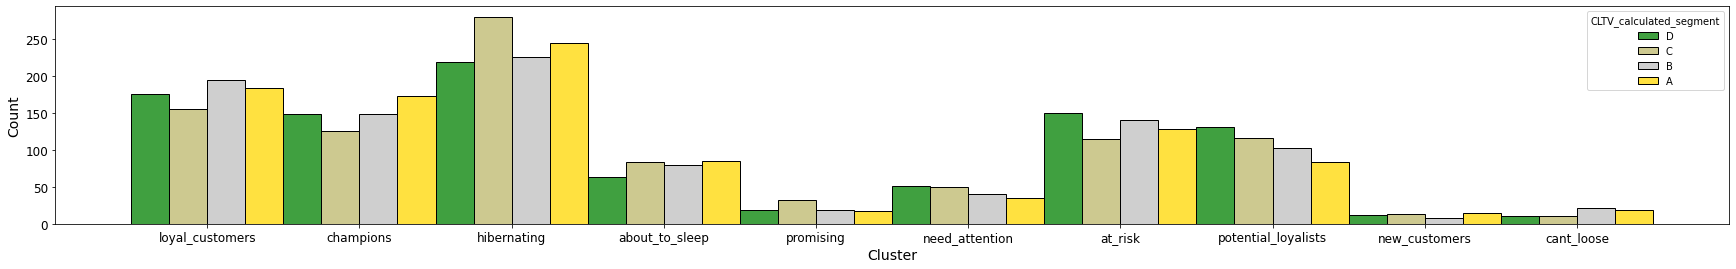

In [44]:
plt.figure( figsize = (30, 4) )
#
#
g = sns.histplot(data = cltv_df, hue = 'CLTV_calculated_segment', x = 'Segment', multiple = 'dodge', color = "lime")
#
plt.xticks( size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

## CLTV Predicted


**Cohort model:** Instead of simply assuming all the customers to be one group, we can try to split them into multiple groups and calculate the CLTV for each group.

Note: recency value customized. (One of the key differences between RFM and CLTV)

<br />

**Beta Geometric / Negative Binomial Distribution (BG-NBD)**

In short, expected sales value. Used to estimate how many purchases customers can make over a period of time

This method computes the probability that a customer with history (frequency, recency_weekly, T_weekly) is currently alive (relationship between recency & frequency).

<br />

**Gamma Gamma**

-conditional expected number of purchases up to time-

<br />
<br />

Notes: 
1. There should be no correlation between the frequency of transactions and their monetary value.
2. We are considering only customers who made repeat purchases with the business i.e., frequency > 0. Because, if the frequency is 0, it means that they are a one-time customer and are considered already dead.

<br />

---

<br />

Parameters

- **Frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- **Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
- **Monetary_avg** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.


In [55]:
today_date = dt.date(2012, 12, 11)

cltv_df = df.groupby('CustomerID').agg(
    {'Date':      [ lambda date: (date.max() - date.min()).days,   # Count of days the customer had a purchase on.
                    lambda date: (today_date - date.min()).days ], # Age of the customer 
     'InvoiceNo':   lambda num: num.nunique() - 1,                 # Νumber of repeat purchases the customer has made
     'Revenue':     lambda Revenue: Revenue.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['Recency', 'T', 'Frequency', 'Monetary']

In [56]:
# Calculate Average Monetary
# 
cltv_df["Monetary_avg"] = cltv_df["Monetary"] / (cltv_df["Frequency"] + 1)
cltv_df.drop(['Monetary'], axis = 1, inplace = True) # Not needed any more


# Recency filter
#
cltv_df = cltv_df[(cltv_df['Frequency'] > 0)]


# Tenure on weekly scale
#
cltv_df["Recency"] = cltv_df["Recency"] / 7.0
cltv_df["T"]       = cltv_df["T"]       / 7.0 

### Basic Frequency/Recency analysis using the BG/NBD model

In [57]:
from lifetimes             import BetaGeoFitter

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# BG/NBD Model
#

# Setup model
bgf = BetaGeoFitter(penalizer_coef = 1e-4)

# Fit model
bgf.fit(frequency = cltv_df['Frequency'],
        recency   = cltv_df['Recency'],
        T         = cltv_df['T'])

print('[INFO] BG/NBD model trained')

[INFO] BG/NBD model trained


In [58]:
# from lifetimes.utils import calibration_and_holdout_data

# summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'Date',
#                                               calibration_period_end = '2011-09-01',
#                                               observation_period_end = '2011-12-10',
#                                               monetary_value_col     = 'Revenue')

In [59]:
# from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

# bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

# plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Frequency/Recency matrix

Frequency/Recency matrix computes the expected number of transactions a customer is to make in the next time period, given the R(age at last purchase) and F (the number of repeat transactions made).

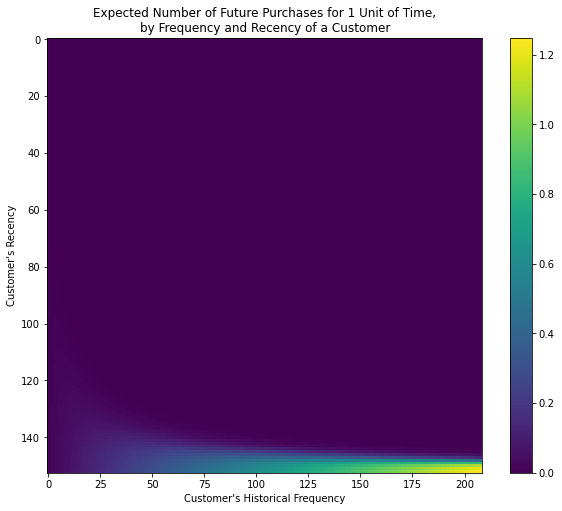

In [60]:
from lifetimes.plotting import plot_frequency_recency_matrix

plt.figure( figsize = (10, 8) )
plot_frequency_recency_matrix( bgf );

### Probability that each customer is alive

Visualize is the probability that each customer is alive based on their frequency and recency

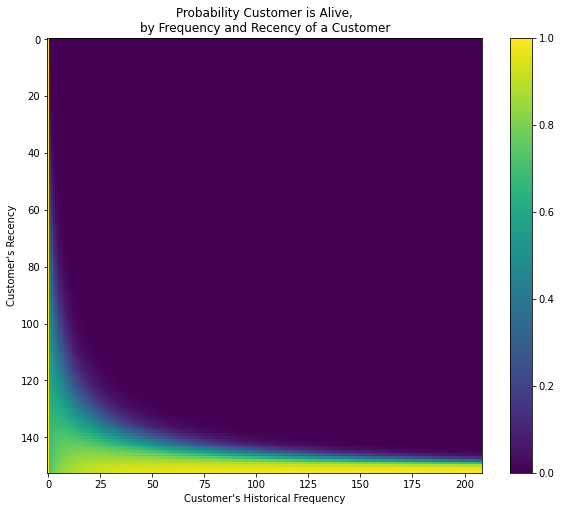

In [61]:
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure( figsize = (10, 8) )
plot_probability_alive_matrix( bgf );

**Findings:** 

- If a customer has bought 200 times from you (Frequency), and their latest purchase was when they were 75 weeks old (Recency), then they are your best customer (bottom-right). 

- The coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

- There’s also that beautiful “tail” around (50, 80). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

### Assessing model fit

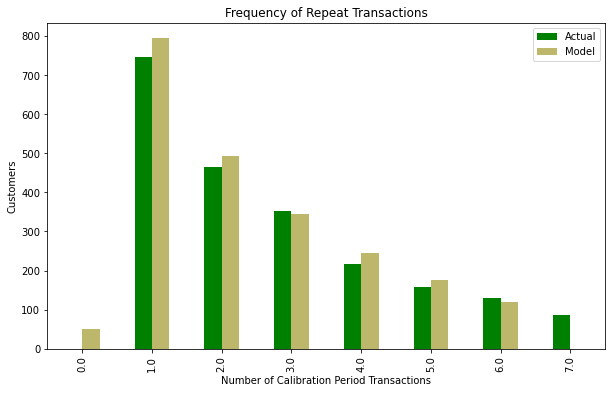

In [62]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions( bgf, figsize = (10, 6) );

#### Top 10 customers expected to make the most purchases in a week


In [63]:
cltv_df['predicted_purchases_1w'] =  bgf.conditional_expected_number_of_purchases_up_to_time(t         = 1, # 4 weeks = 1 month
                                                                                             frequency = cltv_df['Frequency'],
                                                                                             recency   = cltv_df['Recency'],
                                                                                             T         = cltv_df['T'])
                                                        
print('[INFO] Total amount of transactions = %.2f' % cltv_df['predicted_purchases_1w'].sum())

cltv_df['predicted_purchases_1w'].sort_values(ascending = False).head(10)

[INFO] Total amount of transactions = 6.10


CustomerID
16203    0.010235
16150    0.010105
14307    0.009884
14775    0.009613
17802    0.009496
15983    0.009438
14449    0.009422
12868    0.009369
15525    0.009138
13941    0.008952
Name: predicted_purchases_1w, dtype: float64

#### Top 10 customers expected to make the most purchases in a month


In [64]:
cltv_df['predicted_purchases_1M'] =  bgf.conditional_expected_number_of_purchases_up_to_time(t         = 4, # 4 weeks = 1 month
                                                                                             frequency = cltv_df['Frequency'],
                                                                                             recency   = cltv_df['Recency'],
                                                                                             T         = cltv_df['T'])
                                                        
print('[INFO] Total amount of transactions = %.2f' % cltv_df['predicted_purchases_1M'].sum())

cltv_df['predicted_purchases_1M'].sort_values(ascending = False).head(10)

[INFO] Total amount of transactions = 24.03


CustomerID
16203    0.040493
16150    0.039946
14307    0.039056
14775    0.038071
17802    0.037609
15983    0.037349
14449    0.037276
12868    0.037019
15525    0.036201
13941    0.035385
Name: predicted_purchases_1M, dtype: float64

#### Top 10 customers expected to make the most purchases in next 6 months & total amount of transactions

In [65]:
cltv_df['predicted_purchases_6M'] =  bgf.conditional_expected_number_of_purchases_up_to_time(t         = 4*6, # 4*6 weeks = 6 months
                                                                                             frequency = cltv_df['Frequency'],
                                                                                             recency   = cltv_df['Recency'],
                                                                                             T         = cltv_df['T'])

                                                        
print('[INFO] Total amount of transactions = %.2f' % cltv_df['predicted_purchases_6M'].sum())

cltv_df['predicted_purchases_6M'].sort_values(ascending = False).head(10)




[INFO] Total amount of transactions = 131.40


CustomerID
16203    0.226493
16150    0.222232
14307    0.216731
14775    0.214315
17802    0.211717
15983    0.209283
14449    0.208499
12868    0.205425
15525    0.204120
13941    0.196856
Name: predicted_purchases_6M, dtype: float64

### Gamma Gamma model

#### Gamma-Gamma model and the independence assumption

- This submodel assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [66]:
Correlation = cltv_df[['Frequency', 'Monetary_avg']].corr().iloc[0,1]


if (Correlation > 0.1):
    print('[WARNING] Correlation between Frequency & Monetary_avg is over 0.1')
else:
    print('[INFO] Correlation between Frequency & Monetary_avg is %.4f' % Correlation)


[INFO] Correlation between Frequency & Monetary_avg is 0.0191


In [67]:
from lifetimes             import GammaGammaFitter

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Gamma Gamma model
#

# Setup model
ggf = GammaGammaFitter(penalizer_coef = 0.1)

# Fit model
ggf.fit(frequency      = cltv_df['Frequency'] + 1, 
        monetary_value = cltv_df['Monetary_avg'])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 1.00, q: 0.18, v: 0.94>

#### The top 10 customers expected to be most valuable

In [68]:
cltv_df['Conditional_expected_average_profit'] = ggf.conditional_expected_average_profit(frequency      = cltv_df['Frequency'],
                                                                                         monetary_value = cltv_df['Monetary_avg'])

print('[INFO] Expected conditional average profit: %s, Average profit: %s' % (cltv_df['Conditional_expected_average_profit'].mean(), cltv_df[cltv_df['Frequency']>0]['Monetary_avg'].mean()))


cltv_df['Conditional_expected_average_profit'].sort_values(ascending = False).head(10)


[INFO] Expected conditional average profit: 1050.296511876646, Average profit: 397.18367345554583


CustomerID
16446    469416.419528
15749     25173.131526
15098     22562.990324
16984     12491.517319
18087     11305.593895
16240     10366.841175
16253     10269.488629
13952      9063.618242
13868      8900.534615
17672      8860.495803
Name: Conditional_expected_average_profit, dtype: float64

### Prediction of CLTV using BG/NBD and Gamma Gamma models

In [69]:
cltv_df.head(4)

,Recency,T,Frequency,Monetary_avg,predicted_purchases_1w,predicted_purchases_1M,predicted_purchases_6M,Conditional_expected_average_profit
CustomerID,,,,,,,,
12747,79.142857,134.857143,10,381.455455,1.856695e-03,7.306187e-03,3.954013e-02,415.655942
12748,98.857143,152.000000,208,161.338421,4.487966e-34,1.758276e-33,9.268942e-33,161.981945
12749,44.714286,100.428571,4,818.176000,3.614185e-03,1.421735e-02,7.682568e-02,1029.625202
12820,40.285714,99.142857,3,235.585000,3.749952e-03,1.476680e-02,8.030125e-02,324.711954


In [70]:
discount_rate = 0.01


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 1 MONTH =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
clv_df = ggf.customer_lifetime_value(bgf,
                                     cltv_df['Frequency'],
                                     cltv_df['Recency'],
                                     cltv_df['T'],
                                     cltv_df['Monetary_avg'],
                                     time          = 1, # months
                                     freq          = "W",
                                     discount_rate = discount_rate)

# Reset index
clv_df = clv_df.reset_index()

# Rename column
clv_df.rename(columns = {'clv': '1M_clv'}, inplace = True)



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 6 MONTHS =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
clv_df['6M_clv'] = ggf.customer_lifetime_value(bgf,
                                               cltv_df['Frequency'],
                                               cltv_df['Recency'],
                                               cltv_df['T'],
                                               cltv_df['Monetary_avg'],
                                               time          = 6, # months
                                               freq          = "W",
                                               discount_rate = discount_rate).values



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 6 MONTHs =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
clv_df['12M_clv'] = ggf.customer_lifetime_value(bgf,
                                                cltv_df['Frequency'],
                                                cltv_df['Recency'],
                                                cltv_df['T'],
                                                cltv_df['Monetary_avg'],
                                                time          = 12, # months
                                                freq          = "W",
                                                discount_rate = discount_rate).values


In [71]:
# Setup scaler
# 
scaler = MinMaxScaler()

clv_df[ ['1M_clv_scaled', '6M_clv_scaled', '12M_clv_scaled']] = scaler.fit_transform( clv_df[ ['1M_clv', '6M_clv', '12M_clv']])

In [72]:
clv_df.head( 5 )

,CustomerID,1M_clv,6M_clv,12M_clv,1M_clv_scaled,6M_clv_scaled,12M_clv_scaled
0,12747,3.260037e+00,1.709262e+01,2.955134e+01,6.123900e-04,6.050474e-04,5.969480e-04
1,12748,3.055872e-31,1.558184e-30,2.623901e-30,7.538996e-36,6.518326e-36,5.610426e-36
2,12749,1.571376e+01,8.225921e+01,1.421197e+02,2.951792e-03,2.911825e-03,2.870870e-03
3,12820,5.147759e+00,2.712969e+01,4.718312e+01,9.669939e-04,9.603412e-04,9.531163e-04
4,12822,1.060851e+01,5.522433e+01,9.508090e+01,1.992783e-03,1.954840e-03,1.920669e-03


**CLTV Segmentation**

Since we try to create better segmentation and marketing strategies based on RFM and CLTV we will also create segments based on our CLTV. ‘A’ for our best customers and ‘D’ for the worst.

In [73]:
# Add clv segment
# 
clv_df["cltv_segment"] = pd.qcut(clv_df["12M_clv_scaled"], 4, labels=["D", "C", "B", "A"])


# Add RFM segment
#
clv_df = clv_df.merge(RFM.reset_index()[['CustomerID', 'Segment']], on = 'CustomerID') # Merging RFM

# Visualize DataFrame
#
clv_df.head( 5 )


,CustomerID,1M_clv,6M_clv,12M_clv,1M_clv_scaled,6M_clv_scaled,12M_clv_scaled,cltv_segment,Segment
0,12747,3.260037e+00,1.709262e+01,2.955134e+01,6.123900e-04,6.050474e-04,5.969480e-04,C,loyal_customers
1,12748,3.055872e-31,1.558184e-30,2.623901e-30,7.538996e-36,6.518326e-36,5.610426e-36,D,champions
2,12749,1.571376e+01,8.225921e+01,1.421197e+02,2.951792e-03,2.911825e-03,2.870870e-03,A,loyal_customers
3,12820,5.147759e+00,2.712969e+01,4.718312e+01,9.669939e-04,9.603412e-04,9.531163e-04,B,loyal_customers
4,12822,1.060851e+01,5.522433e+01,9.508090e+01,1.992783e-03,1.954840e-03,1.920669e-03,B,about_to_sleep


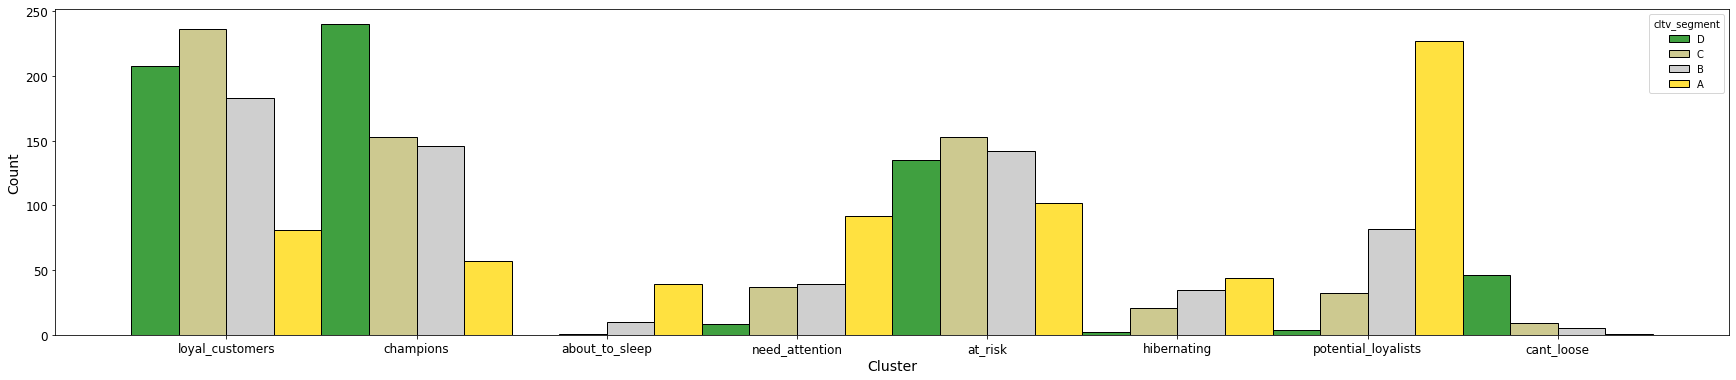

In [74]:
plt.figure( figsize = (30, 6) )
#
#
sns.histplot(data = clv_df, x = 'Segment', hue = 'cltv_segment', multiple="dodge")
#
plt.xticks( size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

# final.groupby(['cltv_segment', 'Segment']).count()[ ['CustomerID'] ]


In [75]:
# clv_df.groupby(['Segment_x', 'cltv_segment']).count()[ ['CustomerID'] ]